In [ ]:
# extract newspaper names/counts from tar files

import csv
import re
import os
import tarfile
from collections import Counter, defaultdict
from concurrent.futures import ThreadPoolExecutor, as_completed
from glob import glob

# Try to use orjson (much faster), fall back to stdlib json
try:
    import orjson as json
    def load_json(f):
        return json.loads(f.read())
except ImportError:
    import json
    def load_json(f):
        return json.load(f)

# Optional: progress bar
try:
    from tqdm import tqdm
except ImportError:
    def tqdm(iterable, **kwargs):
        return iterable

data_folder = "data/American Stories Raw"

# Pre-compile regex patterns (avoid recompilation per call)
NAME_PATTERN = re.compile(r'^([^(\[]+)')
LOCATION_PATTERN = re.compile(r'\(([^)]+)\)')
BRACKET_PATTERN = re.compile(r'\[([^\]]+)\]')
BRACKET_REMOVE_PATTERN = re.compile(r'\s*\[[^\]]+\]')
YEAR_DIGITS_PATTERN = re.compile(r'\d{4}.*')
FILENAME_YEAR_PATTERN = re.compile(r'(\d{4})')

# State abbreviation mapping (unchanged)
STATE_ABBREV = {
    'al': 'Alabama', 'ak': 'Alaska', 'az': 'Arizona', 'ar': 'Arkansas',
    'ca': 'California', 'co': 'Colorado', 'ct': 'Connecticut', 'de': 'Delaware',
    'fl': 'Florida', 'ga': 'Georgia', 'hi': 'Hawaii', 'id': 'Idaho',
    'il': 'Illinois', 'in': 'Indiana', 'ia': 'Iowa', 'ks': 'Kansas', 'kan': 'Kansas',
    'ky': 'Kentucky', 'la': 'Louisiana', 'me': 'Maine', 'md': 'Maryland',
    'ma': 'Massachusetts', 'mi': 'Michigan', 'mn': 'Minnesota', 'ms': 'Mississippi',
    'mo': 'Missouri', 'mt': 'Montana', 'ne': 'Nebraska', 'nv': 'Nevada',
    'nh': 'New Hampshire', 'nj': 'New Jersey', 'nm': 'New Mexico', 'ny': 'New York',
    'nc': 'North Carolina', 'nd': 'North Dakota', 'oh': 'Ohio', 'ohio': 'Ohio',
    'ok': 'Oklahoma', 'or': 'Oregon', 'pa': 'Pennsylvania', 'ri': 'Rhode Island',
    'sc': 'South Carolina', 's.c': 'South Carolina',
    'sd': 'South Dakota', 's.d': 'South Dakota',
    'tn': 'Tennessee', 'tx': 'Texas', 'ut': 'Utah',
    'vt': 'Vermont', 'va': 'Virginia', 'wa': 'Washington', 'wv': 'West Virginia',
    'wi': 'Wisconsin', 'wis': 'Wisconsin', 'wy': 'Wyoming',
    'd.c': 'District of Columbia'
}

def extract_info(entry):
    """Extract newspaper name, town, and state from a title string."""
    name_match = NAME_PATTERN.match(entry)
    name = name_match.group(1).strip().rstrip('.') if name_match else entry
    
    location_match = LOCATION_PATTERN.search(entry)
    town, state = '', ''
    
    if location_match:
        location = location_match.group(1)
        bracket_match = BRACKET_PATTERN.search(location)
        state_abbr = None
        
        if bracket_match:
            state_abbr = bracket_match.group(1).lower().rstrip('.')
            location = BRACKET_REMOVE_PATTERN.sub('', location)
        
        loc_parts = [p.strip() for p in location.split(',')]
        
        if state_abbr:
            town = loc_parts[0] if loc_parts else ''
            state = STATE_ABBREV.get(state_abbr, state_abbr.upper())
        elif len(loc_parts) >= 2:
            town = loc_parts[0]
            state_part = loc_parts[-1].lower().rstrip('.').strip()
            state_part = YEAR_DIGITS_PATTERN.sub('', state_part).strip()
            state = STATE_ABBREV.get(state_part, state_part.upper())
    
    return {'name': name, 'town': town, 'state': state}

def process_tar_file(file_path):
    """Process a single tar file and return (year, {title: (count, issn, lccn)})."""
    match = FILENAME_YEAR_PATTERN.search(os.path.basename(file_path))
    year = match.group(1) if match else None
    
    if not year:
        return None, {}
    
    # Store {title: [count, issn, lccn]}
    data = {}
    
    with tarfile.open(file_path, "r:gz") as tar:
        for member in tar:
            if not member.isfile() or not member.name.endswith(".json"):
                continue
            
            f = tar.extractfile(member)
            if not f:
                continue
                
            try:
                content = load_json(f)
                lccn_obj = content.get('lccn', {})
                title = lccn_obj.get("title", "")
                if title:
                    title_lower = title.lower()
                    if title_lower in data:
                        data[title_lower][0] += 1
                    else:
                        issn = lccn_obj.get("issn", "")
                        lccn = lccn_obj.get("lccn", "")
                        data[title_lower] = [1, issn, lccn]
            except Exception:
                continue
    
    return year, data

def main():
    tar_files = sorted(glob(os.path.join(data_folder, "*.tar.gz")))
    print(f"Found {len(tar_files)} tar files to process")
    
    if not tar_files:
        print("No tar files found!")
        return
    
    # Process files in parallel
    # Store {title: {'years': {year: count}, 'issn': str, 'lccn': str}}
    all_data = defaultdict(lambda: {'years': Counter(), 'issn': '', 'lccn': ''})
    years = set()
    
    # Use number of threads (I/O bound, so can use more than CPU count)
    max_workers = min(16, len(tar_files))
    
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {executor.submit(process_tar_file, f): f for f in tar_files}
        
        for future in tqdm(as_completed(futures), total=len(futures), desc="Processing tar files"):
            year, data = future.result()
            if year:
                years.add(year)
                for title, (count, issn, lccn) in data.items():
                    all_data[title]['years'][year] += count
                    # Store issn/lccn if we don't have them yet (they're the same across years)
                    if issn and not all_data[title]['issn']:
                        all_data[title]['issn'] = issn
                    if lccn and not all_data[title]['lccn']:
                        all_data[title]['lccn'] = lccn
    
    years = sorted(years)
    print(f"\nYears found: {years}")
    
    # Build final results
    results = []
    for title, title_data in all_data.items():
        info = extract_info(title)
        info['issn'] = title_data['issn']
        info['lccn'] = title_data['lccn']
        total = 0
        year_counts = title_data['years']
        for year in years:
            c = year_counts.get(year, 0)
            info[f'{year}_count'] = c
            total += c
        info['total'] = total
        results.append(info)
    
    # Sort by total count descending
    results.sort(key=lambda x: x['total'], reverse=True)
    
    # Write to CSV
    fieldnames = ['name', 'town', 'state', 'issn', 'lccn'] + [f'{y}_count' for y in years] + ['total']
    
    with open('data/newspapers_all_years.csv', 'w', newline='', encoding='utf-8') as f:
        writer = csv.DictWriter(f, fieldnames=fieldnames)
        writer.writeheader()
        writer.writerows(results)
    
    print(f"\nCSV file created with {len(results)} unique newspapers.")
    
    # Preview top 5
    print("\nTop 5 newspapers by total count:")
    for r in results[:5]:
        year_counts_str = ", ".join(f"{y}: {r[f'{y}_count']}" for y in years if r[f'{y}_count'] > 0)
        print(f"  {r['name']} ({r['town']}, {r['state']}) - Total: {r['total']}")
        print(f"    {year_counts_str}")

if __name__ == "__main__":
    main()

Found 22 tar files to process


Processing tar files: 100%|██████████| 22/22 [36:21<00:00, 99.15s/it]   


Years found: ['1869', '1870', '1871', '1872', '1873', '1874', '1875', '1876', '1877', '1878', '1879', '1880', '1881', '1882', '1883', '1884', '1885', '1886', '1887', '1888', '1889', '1890']

CSV file created with 1493 unique newspapers.

Top 5 newspapers by total count:
  new-york tribune (new york, N.Y) - Total: 49609
    1869: 1876, 1870: 1391, 1871: 1547, 1872: 1394, 1873: 1631, 1874: 1462, 1875: 2329, 1876: 1323, 1877: 1829, 1878: 1551, 1879: 1373, 1880: 2424, 1881: 2733, 1882: 2727, 1883: 2843, 1884: 2434, 1885: 2149, 1886: 1935, 1887: 3288, 1888: 3453, 1889: 3920, 1890: 3997
  evening star (washington, District of Columbia) - Total: 32979
    1869: 850, 1870: 1098, 1871: 1324, 1872: 1454, 1873: 1317, 1874: 1276, 1875: 1270, 1876: 1166, 1877: 517, 1878: 1292, 1879: 1349, 1880: 1413, 1881: 1602, 1882: 1663, 1883: 1569, 1884: 1452, 1885: 1570, 1886: 1397, 1887: 1816, 1888: 1915, 1889: 2741, 1890: 2928
  alexandria gazette (alexandria, District of Columbia) - Total: 25698
    1869: 

In [ ]:
# merge duplicates

import pandas as pd

df = pd.read_csv('data/newspapers_all_years.csv')
count_cols = [c for c in df.columns if c.endswith('_count')]
agg = {c: 'sum' for c in count_cols}
agg.update({c: 'first' for c in ['name', 'town', 'state', 'lccn', 'total']})
result = df.groupby('issn', as_index=False).agg(agg)
result = result[df.columns].sort_values('total', ascending=False)
result.to_csv('data/newspapers_all_years.csv', index=False)

In [1]:
import json
import tarfile
import sqlite3
import re
from tqdm import tqdm
from glob import glob

print("Extracting all headlines and articles from raw data")

# --- Set up SQLite ---

DB_PATH = "data/newspapers.db"
con = sqlite3.connect(DB_PATH)
cur = con.cursor()

cur.executescript("""
    CREATE TABLE IF NOT EXISTS headlines (
        lccn TEXT NOT NULL,
        issn TEXT,
        year INTEGER NOT NULL,
        text TEXT NOT NULL
    );
    CREATE TABLE IF NOT EXISTS articles (
        lccn TEXT NOT NULL,
        issn TEXT,
        year INTEGER NOT NULL,
        text TEXT NOT NULL
    );
    CREATE INDEX IF NOT EXISTS idx_headlines_issn_year ON headlines(issn, year);
    CREATE INDEX IF NOT EXISTS idx_articles_issn_year ON articles(issn, year);
    CREATE INDEX IF NOT EXISTS idx_headlines_lccn_year ON headlines(lccn, year);
    CREATE INDEX IF NOT EXISTS idx_articles_lccn_year ON articles(lccn, year);
""")
con.commit()

# --- Helpers ---

def clean(text):
    return ' '.join(text.split())

# --- Process tar files ---

data_folder = "data/American Stories Raw"
BATCH_SIZE = 5000

tar_paths = sorted(glob(f"{data_folder}/*.tar.gz"))
for i, tar_path in enumerate(tar_paths, 1):
    year = int(tar_path.split("_")[-1].replace(".tar.gz", ""))

    # Skip years already processed
    cur.execute("SELECT COUNT(*) FROM headlines WHERE year = ?", (year,))
    if cur.fetchone()[0] > 0:
        print(f"Skipping {year} (already in DB)")
        continue

    headline_batch = []
    article_batch = []
    headline_count = 0
    article_count = 0

    with tarfile.open(tar_path, "r:gz") as tar:
        for member in tqdm(tar.getmembers(), desc=str(year)):
            if not member.name.endswith(".json"):
                continue
            f = tar.extractfile(member)
            if not f:
                continue
            try:
                data = json.load(f)
                lccn = data["lccn"]["lccn"]
                issn = data["lccn"].get("issn")

                for bbox in data.get("bboxes", []):
                    legible = bbox.get("legibility") == "Legible"
                    if not legible:
                        continue

                    cls = bbox.get("class")
                    text = clean(bbox["raw_text"])
                    if not text:
                        continue

                    if cls == "headline":
                        headline_batch.append((lccn, issn, year, text))
                        headline_count += 1
                    elif cls == "article":
                        article_batch.append((lccn, issn, year, text))
                        article_count += 1

                    if len(headline_batch) >= BATCH_SIZE:
                        cur.executemany("INSERT INTO headlines VALUES (?, ?, ?, ?)", headline_batch)
                        headline_batch.clear()
                    if len(article_batch) >= BATCH_SIZE:
                        cur.executemany("INSERT INTO articles VALUES (?, ?, ?, ?)", article_batch)
                        article_batch.clear()

            except Exception:
                continue

    # Flush remaining
    if headline_batch:
        cur.executemany("INSERT INTO headlines VALUES (?, ?, ?, ?)", headline_batch)
    if article_batch:
        cur.executemany("INSERT INTO articles VALUES (?, ?, ?, ?)", article_batch)
    con.commit()

    print(f"  [{i}/{len(tar_paths)}] {year}: {headline_count} headlines, {article_count} articles")

con.close()
print(f"\nDone. Database saved to {DB_PATH}")

Extracting all headlines and articles from raw data


1869: 100%|██████████| 66034/66034 [01:56<00:00, 565.57it/s]


  [1/22] 1869: 1135946 headlines, 1379591 articles


1870: 100%|██████████| 67194/67194 [02:07<00:00, 525.13it/s]


  [2/22] 1870: 1204236 headlines, 1417604 articles


1871: 100%|██████████| 66913/66913 [03:40<00:00, 302.92it/s]


  [3/22] 1871: 1253488 headlines, 1462424 articles


1872: 100%|██████████| 74855/74855 [04:16<00:00, 292.31it/s]


  [4/22] 1872: 1348830 headlines, 1582426 articles


1873: 100%|██████████| 81392/81392 [04:26<00:00, 305.38it/s]


  [5/22] 1873: 1306054 headlines, 1540705 articles


1874: 100%|██████████| 82443/82443 [04:37<00:00, 296.95it/s]


  [6/22] 1874: 1335999 headlines, 1597809 articles


1875: 100%|██████████| 88245/88245 [04:55<00:00, 298.82it/s]


  [7/22] 1875: 1417171 headlines, 1659414 articles


1876: 100%|██████████| 86278/86278 [04:49<00:00, 297.84it/s]


  [8/22] 1876: 1388119 headlines, 1580538 articles


1877: 100%|██████████| 85369/85369 [04:37<00:00, 307.59it/s]


  [9/22] 1877: 1359610 headlines, 1528052 articles


1878: 100%|██████████| 85013/85013 [03:35<00:00, 393.82it/s]


  [10/22] 1878: 1510408 headlines, 1662975 articles


1879: 100%|██████████| 86250/86250 [03:52<00:00, 371.08it/s]


  [11/22] 1879: 1481515 headlines, 1640938 articles


1880: 100%|██████████| 91876/91876 [05:35<00:00, 273.88it/s]


  [12/22] 1880: 1562031 headlines, 1814745 articles


1881: 100%|██████████| 92302/92302 [05:04<00:00, 302.93it/s]


  [13/22] 1881: 1562424 headlines, 1880854 articles


1882: 100%|██████████| 93311/93311 [05:29<00:00, 283.18it/s]


  [14/22] 1882: 1725714 headlines, 2034432 articles


1883: 100%|██████████| 102540/102540 [06:53<00:00, 248.26it/s]


  [15/22] 1883: 1956828 headlines, 2196771 articles


1884: 100%|██████████| 107638/107638 [06:34<00:00, 273.11it/s]


  [16/22] 1884: 2042226 headlines, 2228043 articles


1885: 100%|██████████| 113351/113351 [07:00<00:00, 269.32it/s]


  [17/22] 1885: 2187809 headlines, 2458639 articles


1886: 100%|██████████| 124463/124463 [06:47<00:00, 305.35it/s]


  [18/22] 1886: 2359975 headlines, 2626893 articles


1887: 100%|██████████| 135612/135612 [05:46<00:00, 391.54it/s]


  [19/22] 1887: 2561942 headlines, 2837283 articles


1888: 100%|██████████| 133079/133079 [06:58<00:00, 318.17it/s]


  [20/22] 1888: 2638800 headlines, 2885925 articles


1889: 100%|██████████| 138785/138785 [07:37<00:00, 303.07it/s]


  [21/22] 1889: 2842748 headlines, 3047331 articles


1890: 100%|██████████| 149708/149708 [08:09<00:00, 305.62it/s]


  [22/22] 1890: 3117015 headlines, 3206594 articles

Done. Database saved to data/newspapers.db


In [ ]:
# fix a few duplicates

import sqlite3

DB_PATH = "data/newspapers.db"
con = sqlite3.connect(DB_PATH)
cur = con.cursor()

merges = {
    "2158-9062": ["2158-9054", "2158-8996", "2159-3752"],  # wichita eagle
    "2163-6346": ["2163-6362"],  # homer/claiborne guardian
    "2329-6461": ["2329-6437"],  # great falls tribune
}

for target, sources in merges.items():
    for old in sources:
        for table in ["headlines", "articles"]:
            cur.execute(f"UPDATE {table} SET issn = ? WHERE issn = ?", (target, old))
            print(f"{table}: {old} -> {target} ({cur.rowcount} rows)")

con.commit()
con.close()
print("\nDone.")

headlines: 2158-9054 -> 2158-9062 (200120 rows)
articles: 2158-9054 -> 2158-9062 (275975 rows)
headlines: 2158-8996 -> 2158-9062 (35509 rows)
articles: 2158-8996 -> 2158-9062 (71478 rows)
headlines: 2159-3752 -> 2158-9062 (11289 rows)
articles: 2159-3752 -> 2158-9062 (16739 rows)
headlines: 2163-6362 -> 2163-6346 (4825 rows)
articles: 2163-6362 -> 2163-6346 (9833 rows)
headlines: 2329-6437 -> 2329-6461 (5817 rows)
articles: 2329-6437 -> 2329-6461 (9456 rows)

Done.


In [1]:
# create topic counts

import json
import re
import sqlite3
from collections import Counter

DB_PATH = "data/newspapers.db"

TOPIC_DICTIONARY = {
    "politics_elections": ["vote", "voter", "election", "ballot", "candidate", "party", "democrat", "republican", "campaign", "convention", "nominate", "poll", "ticket", "caucus", "primary"],
    "congress_government": ["congress", "senate", "house", "bill", "law", "passed", "veto", "president", "cabinet", "session", "committee", "amendment", "act", "senator", "representative"],
    "courts_law": ["court", "judge", "trial", "jury", "lawyer", "case", "verdict", "guilty", "sentence", "appeal", "supreme", "justice", "plaintiff", "defendant", "lawsuit"],
    "labor_workers": ["labor", "wage", "strike", "worker", "union", "factory", "employ", "hours", "boss", "mill", "mine", "miner", "coal", "iron", "shop"],
    "business_commerce": ["trade", "market", "price", "sell", "buy", "stock", "firm", "company", "merchant", "goods", "store", "profit", "business", "commercial", "dealer"],
    "finance_money": ["bank", "money", "gold", "silver", "coin", "dollar", "debt", "bond", "loan", "credit", "currency", "treasury", "mint", "panic", "deposit"],
    "railroads_transportation": ["railroad", "rail", "train", "depot", "freight", "passenger", "track", "line", "station", "route", "fare", "car", "engine", "express", "trunk"],
    "agriculture_farming": ["farm", "farmer", "crop", "wheat", "corn", "cattle", "harvest", "land", "acre", "grain", "wool", "cotton", "hog", "market", "price"],
    "immigration_foreign": ["immigrant", "foreign", "chinese", "irish", "german", "alien", "native", "citizen", "naturalize", "emigrant", "passport", "steamer", "arrival"],
    "crime_police": ["murder", "arrest", "police", "thief", "robbery", "prison", "criminal", "crime", "officer", "stolen", "gang", "mob", "riot", "lynch", "jail"],
    "_baseline_english": [
        "the", "a", "an", "this", "that", "these", "those",
        "and", "or", "but", "for", "with", "from", "by", "at", "on", "in", "to", "of",
        "he", "she", "it", "they", "we", "his", "her", "their", "who", "what",
        "is", "are", "was", "were", "be", "been", "have", "has", "had", "will", "would",
        "said", "says", "made", "came", "went", "took", "gave", "found", "left",
        "man", "men", "woman", "city", "state", "country", "day", "year", "time",
        "new", "old", "great", "last", "first", "two", "three", "one", "all", "more",
        "today", "yesterday", "here", "there", "now", "after", "before", "over", "about"
    ],
}

TERM_TO_TOPICS = {}
for topic, terms in TOPIC_DICTIONARY.items():
    for term in terms:
        TERM_TO_TOPICS.setdefault(term, []).append(topic)

def tokenize(text):
    return re.findall(r'[a-z]+', text.lower())

def count_topics_in_headlines(headlines):
    counts = Counter()
    total = 0
    for headline in headlines:
        for token in tokenize(headline):
            total += 1
            for topic in TERM_TO_TOPICS.get(token, []):
                counts[topic] += 1
    return dict(counts), total

def calculate_ocr_grade(baseline_hits, total_tokens):
    if total_tokens == 0:
        return 0.0
    baseline_rate = baseline_hits / total_tokens
    EXPECTED_BASELINE_RATE = 0.30
    grade = min(1.0, baseline_rate / EXPECTED_BASELINE_RATE)
    return round(grade, 3)

def main():
    con = sqlite3.connect(DB_PATH)
    cur = con.cursor()

    # Get all distinct years
    cur.execute("SELECT DISTINCT year FROM headlines ORDER BY year")
    years = [row[0] for row in cur.fetchall()]

    all_results = {}

    for year in years:
        print(f"Processing {year}...")

        # Group headlines by issn for this year
        cur.execute("SELECT issn, text FROM headlines WHERE year = ?", (year,))

        papers = {}
        for issn, text in cur:
            if issn is None:
                continue
            papers.setdefault(issn, []).append(text)

        year_results = {}
        for issn, headlines in papers.items():
            topic_counts, total_tokens = count_topics_in_headlines(headlines)

            baseline_hits = topic_counts.pop("_baseline_english", 0)
            ocr_grade = calculate_ocr_grade(baseline_hits, total_tokens)

            year_results[issn] = {
                "topic_counts": topic_counts,
                "total_headlines": len(headlines),
                "total_tokens": total_tokens,
                "baseline_hits": baseline_hits,
                "ocr_grade": ocr_grade,
                "normalized_counts": {
                    topic: round((count / total_tokens) * 1000 / max(ocr_grade, 0.1), 2)
                    for topic, count in topic_counts.items()
                } if total_tokens > 0 and topic_counts else {}
            }

        all_results[str(year)] = year_results

    con.close()

    # Print OCR quality summary
    print("\n=== OCR Quality Summary ===")
    for year in sorted(all_results.keys()):
        print(f"\n{year}:")
        for issn, stats in sorted(all_results[year].items(), key=lambda x: x[1]["ocr_grade"], reverse=True):
            grade_pct = stats["ocr_grade"] * 100
            print(f"  {issn}: {grade_pct:.1f}% readable ({stats['baseline_hits']}/{stats['total_tokens']} baseline words)")

    with open("data/topic_counts.json", "w") as out:
        json.dump(all_results, out, indent=2)

    print(f"\nDone. Processed {len(years)} years -> topic_counts.json")

if __name__ == "__main__":
    main()

Processing 1869...
Processing 1870...
Processing 1871...
Processing 1872...
Processing 1873...
Processing 1874...
Processing 1875...
Processing 1876...
Processing 1877...
Processing 1878...
Processing 1879...
Processing 1880...
Processing 1881...
Processing 1882...
Processing 1883...
Processing 1884...
Processing 1885...
Processing 1886...
Processing 1887...
Processing 1888...
Processing 1889...
Processing 1890...

=== OCR Quality Summary ===

1869:
  2472-789X: 100.0% readable (88/265 baseline words)
  2375-7582: 96.0% readable (159/552 baseline words)
  2379-6332: 93.2% readable (4645/16618 baseline words)
  2333-2921: 85.6% readable (311/1211 baseline words)
  2767-438X: 84.9% readable (4052/15900 baseline words)
  2333-4541: 83.7% readable (270/1075 baseline words)
  2379-3082: 82.9% readable (4899/19692 baseline words)
  2374-6041: 82.9% readable (2173/8735 baseline words)
  2166-1774: 82.8% readable (47217/190115 baseline words)
  2373-2377: 82.6% readable (2637/10639 baseline wo

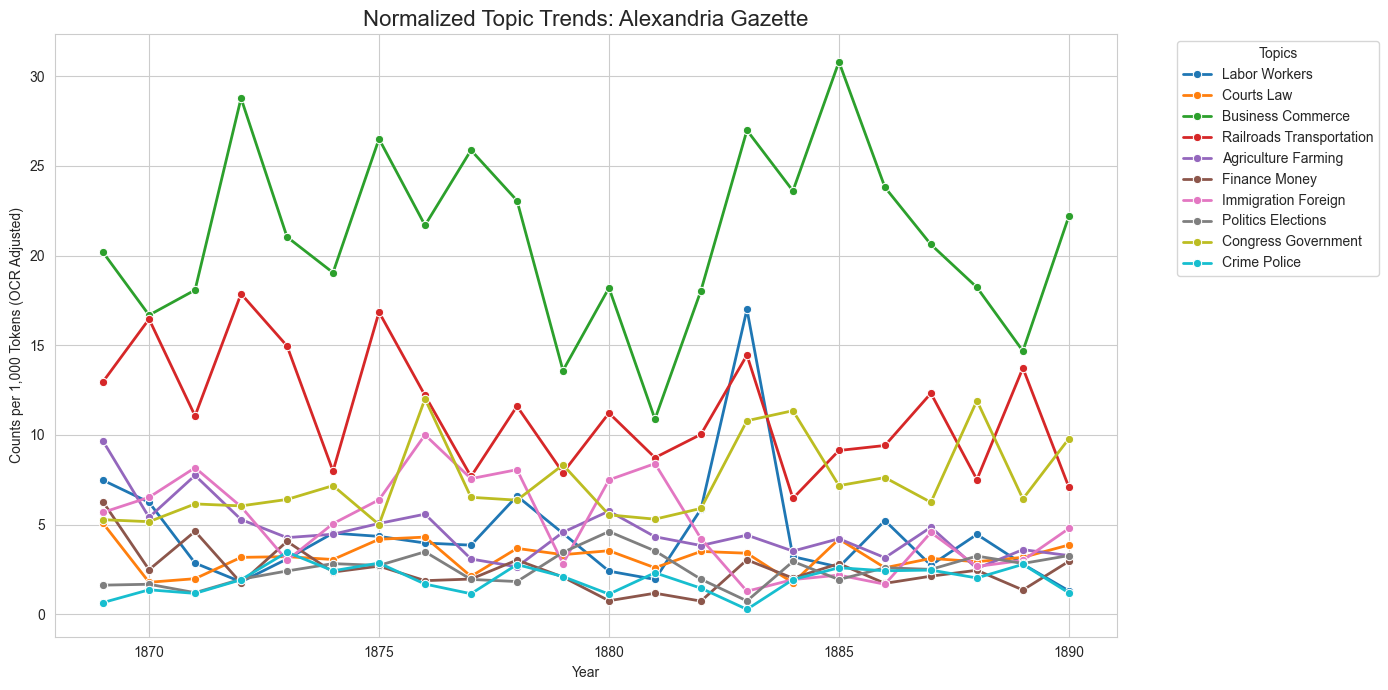

In [ ]:
# visualize topic counts

import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your data (assuming it's in a file named 'data.json')
with open('data/topic_counts.json', 'r') as f:
    data = json.load(f)

def plot_normalized_trends(json_data, target_paper="alexandria gazette"):
    rows = []
    
    # Iterate through each year in the JSON
    for year, papers in json_data.items():
        # Check if the specific newspaper exists for that year
        if target_paper in papers:
            paper_entry = papers[target_paper]
            
            # Access the 'normalized_counts' dictionary
            if "normalized_counts" in paper_entry:
                norm_counts = paper_entry["normalized_counts"]
                
                for topic, value in norm_counts.items():
                    rows.append({
                        "Year": int(year),
                        "Topic": topic.replace("_", " ").title(),
                        "Normalized Count": value
                    })
    
    # Create DataFrame
    df = pd.DataFrame(rows)
    
    if df.empty:
        print(f"No data found for {target_paper}")
        return

    # Plotting
    plt.figure(figsize=(14, 7))
    sns.set_style("whitegrid")
    
    # Create the line plot
    plot = sns.lineplot(
        data=df, 
        x="Year", 
        y="Normalized Count", 
        hue="Topic", 
        marker="o",
        linewidth=2
    )
    
    # Formatting
    plt.title(f"Normalized Topic Trends: {target_paper.title()}", fontsize=16)
    plt.ylabel("Counts per 1,000 Tokens (OCR Adjusted)")
    plt.xlabel("Year")
    
    # Move legend outside the plot area
    plt.legend(title="Topics", bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()

# Example usage:
plot_normalized_trends(data)

In [ ]:
# filter down to only newspapers that have 3 years of 10+ scans

import pandas as pd

df = pd.read_csv('data/newspapers_all_years_updated.csv')
year_cols = [c for c in df.columns if c.endswith('_count') and c != 'total']
df = df[(df[year_cols] >= 10).sum(axis=1) >= 3]
df.to_csv('data/newspapers_all_years_updated.csv', index=False)

In [13]:
# match our newspapers from Melissa Dell onto Rowell's

import csv
import html
import re
import unicodedata
from thefuzz import fuzz, process

# Configuration
FUZZY_THRESHOLD = 80  # Adjust this threshold as needed (0-100)

# Special case mappings for known location mismatches
# Format: (town, state_first_letter) in newspapers_all_years -> (town, state_first_letter) in master
LOCATION_OVERRIDES = {
    ('alexandria', 'd'): ('alexandria', 'v'),  # Alexandria Gazette: DC -> Virginia
}

def load_csv(filepath):
    with open(filepath, 'r', encoding='utf-8') as f:
        reader = csv.DictReader(f)
        return list(reader)

def normalize(text):
    """Normalize text for comparison."""
    if text is None:
        return ""
    return text.strip().lower()

def strip_court_house(text):
    """Remove 'c.h.' (court house) suffix from a normalized string."""
    return re.sub(r'\s*c\.?\s*h\.?\s*$', '', text).strip()

def normalize_unicode(text):
    """Decode HTML entities and remove diacritics."""
    if text is None:
        return ""
    # Decode HTML entities like &amp; -> & and &#39; -> '
    text = html.unescape(text)
    # Manual fix for known encoding issue
    text = text.replace('phå"nix', 'phenix')
    # Normalize to NFD, then remove combining characters (accents/diacritics)
    normalized = unicodedata.normalize('NFD', text)
    return ''.join(c for c in normalized if unicodedata.category(c) != 'Mn')

def remove_the(text):
    """Remove 'the' from beginning of newspaper name."""
    if text is None:
        return ""
    text = text.strip()
    if text.lower().startswith('the '):
        return text[4:]
    return text

def remove_town_from_name(name, town):
    """Remove town name from newspaper name, handling special characters."""
    if not name or not town:
        return name
    # Create pattern that matches town with optional special chars between words
    # e.g., "new york" matches "new-york", "new york", "new_york", etc.
    town_words = town.lower().split()
    pattern = r'[\s\-_]*'.join(re.escape(word) for word in town_words)
    # Remove town from name (case insensitive), including trailing space/special chars
    result = re.sub(pattern + r'[\s\-_]*', '', name, flags=re.IGNORECASE)
    return result.strip()

def remove_daily(name):
    """Remove 'daily' from newspaper name."""
    if not name:
        return name
    result = re.sub(r'\b(daily|weekly)\b[\s\-_]*', '', name, flags=re.IGNORECASE)
    return result.strip()

def has_sufficient_yearly_counts(row, min_count=10, min_years=3):
    """Check if newspaper has at least min_count in at least min_years separate years."""
    years_meeting_threshold = 0
    for key, value in row.items():
        if key.endswith('_count'):
            try:
                count = int(value) if value else 0
                if count >= min_count:
                    years_meeting_threshold += 1
            except ValueError:
                continue
    return years_meeting_threshold >= min_years

def get_state_first_letter(state):
    """Get first letter of state, normalized."""
    if state is None or len(state.strip()) == 0:
        return ""
    return state.strip()[0].lower()

def get_lookup_keys(town, state_letter):
    """Get all lookup keys to try, including any overrides."""
    keys = [(town, state_letter)]
    original_key = (town, state_letter)
    if original_key in LOCATION_OVERRIDES:
        keys.append(LOCATION_OVERRIDES[original_key])
    return keys

def main():
    # Load both CSVs
    master = load_csv('data/master.csv')
    newspapers = load_csv('data/newspapers_all_years_updated.csv')
    
    matches = []
    unmatched_diagnostics = []
    
    # Build a lookup from master by (town, state_first_letter)
    master_by_location = {}
    for idx, row in enumerate(master):
        town = normalize(row.get('town', ''))
        state_letter = get_state_first_letter(row.get('state', ''))
        key = (town, state_letter)
        if key not in master_by_location:
            master_by_location[key] = []
        master_by_location[key].append({
            'name': normalize_unicode(row.get('newspaper_name', '')),
            'idx': idx
        })
    
    # Process each row in newspapers_all_years
    for news_row in newspapers:
        # Skip if doesn't meet yearly count threshold
        if not has_sufficient_yearly_counts(news_row):
            continue
        
        news_town = strip_court_house(normalize(news_row.get('town', '')))
        news_state_letter = get_state_first_letter(news_row.get('state', ''))
        news_name = news_row.get('name', '')
        news_issn = news_row.get('issn', '')
        # Normalize unicode before further processing
        news_name_normalized = normalize_unicode(news_name)
        # Remove "the" and town name for matching
        news_name_for_matching = remove_town_from_name(remove_the(news_name_normalized), news_row.get('town', ''))
        
        # Get all keys to try (original + any overrides)
        keys_to_try = get_lookup_keys(news_town, news_state_letter)
        
        # Check if there are newspapers in master with same town and state first letter
        matched = False
        for key in keys_to_try:
            if matched:
                break
                
            if key in master_by_location:
                candidates = master_by_location[key]
                
                if candidates:
                    candidate_names = [c['name'] for c in candidates]
                    
                    # First pass: match with "the" and town removed
                    best_match, score = process.extractOne(
                        news_name_for_matching, 
                        candidate_names, 
                        scorer=fuzz.token_sort_ratio
                    )
                    
                    if score >= FUZZY_THRESHOLD:
                        master_idx = next(c['idx'] for c in candidates if c['name'] == best_match)
                        matches.append({
                            'newspapers_all_years_name': news_name,
                            'issn': news_issn,
                            'master_name': best_match,
                            'master_id': master_idx
                        })
                        matched = True
                    else:
                        # Second pass: also remove "daily"
                        news_name_no_daily = remove_daily(news_name_for_matching)
                        
                        if news_name_no_daily and news_name_no_daily != news_name_for_matching:
                            best_match, score = process.extractOne(
                                news_name_no_daily, 
                                candidate_names, 
                                scorer=fuzz.token_sort_ratio
                            )
                            
                            if score >= FUZZY_THRESHOLD:
                                master_idx = next(c['idx'] for c in candidates if c['name'] == best_match)
                                matches.append({
                                    'newspapers_all_years_name': news_name,
                                    'issn': news_issn,
                                    'master_name': best_match,
                                    'master_id': master_idx
                                })
                                matched = True
        
        # If no match found, still add the row with empty master_name
        if not matched:
            matches.append({
                'newspapers_all_years_name': news_name,
                'issn': news_issn,
                'master_name': '',
                'master_id': ''
            })
            
            # Collect diagnostic info for unmatched papers
            keys_to_try = get_lookup_keys(news_town, news_state_letter)
            all_candidates = []
            town_found = False
            for key in keys_to_try:
                if key in master_by_location:
                    town_found = True
                    all_candidates.extend(master_by_location[key])
            
            unmatched_diagnostics.append({
                'name': news_name,
                'town': news_row.get('town', ''),
                'state': news_row.get('state', ''),
                'issn': news_issn,
                'lccn': news_row.get('lccn', ''),
                'town_found': town_found,
                'candidates': all_candidates
            })
    
    # Write output
    with open('data/matches.csv', 'w', newline='', encoding='utf-8') as f:
        writer = csv.DictWriter(f, fieldnames=['newspapers_all_years_name', 'issn', 'master_name', 'master_id'])
        writer.writeheader()
        writer.writerows(matches)
    
    # Write unmatched diagnostics as text file
    with open('unmatched_diagnostics.txt', 'w', encoding='utf-8') as f:
        f.write("UNMATCHED NEWSPAPERS DIAGNOSTICS\n")
        f.write("=" * 60 + "\n\n")
        f.write(f"Total unmatched: {len(unmatched_diagnostics)}\n\n")
        
        for i, diag in enumerate(unmatched_diagnostics, 1):
            f.write(f"--- Entry {i} ---\n")
            f.write(f"Name:  {diag['name']}\n")
            f.write(f"Town:  {diag['town']}\n")
            f.write(f"State: {diag['state']}\n")
            f.write(f"ISSN:  {diag['issn']}\n")
            f.write(f"LCCN:  {diag['lccn']}\n")
            f.write(f"Town found in master: {'Yes' if diag['town_found'] else 'No'}\n")
            if diag['candidates']:
                f.write("Master candidates in town:\n")
                for candidate in diag['candidates']:
                    f.write(f"  - {candidate['name']} (master_id: {candidate['idx']})\n")
            else:
                f.write("Master candidates in town: (none)\n")
            f.write("\n")
    
    matched_count = sum(1 for m in matches if m['master_name'])
    unmatched_count = len(matches) - matched_count
    print(f"Found {matched_count} matches and {unmatched_count} unmatched. Output written to data/matches.csv")
    print(f"Unmatched diagnostics written to unmatched_diagnostics.txt")

if __name__ == '__main__':
    main()

Found 443 matches and 163 unmatched. Output written to data/matches.csv
Unmatched diagnostics written to unmatched_diagnostics.txt


In [14]:
import csv

# Manual matches identified from diagnostic review
# Format: (newspapers_all_years_name, master_name, master_id)
MANUAL_MATCHES = [
    ("idaho semi-weekly world", "Idaho Worlds", 12622),
    ("carson daily appeal", "APPEAL", 30291),
    ("the aegis &amp", "Zgis and Intelligencer", 22316),
    ("vermont phå\u201cnix", "Vermont Phenix", 45226),
    ("the jackson standard", "Standard", 38082),
    ("the evening argus", "Argus", 15329),
    ("hermanner volksblatt", "Hermanner Volksblatt", 27735),
    ("wheeling sunday register", "Register", 46685),
    ("the new bloomfield, pa. times", "Times", 40864),
    ("the bloomfield times", "Times", 40864),
    ("maryland independent", "INDEPENDENT", 22504),
    ("the daily morning astorian", "MORNING ASTORIAN", 39254),
    ("the press", "Tolland County Press", 10778),
    ("the daily astorian", "Astorian", 39263),
    ("the manning times", "KK. TIMES", 42959),
    ("louisiana capitolian", "CAPITOLIAN ADVOCATE", 21548),
    ("national opinion", "Opinion", 45221),
    ("idaho county free press", "CO. FREE PRESS", 12615),
    ("the columbia herald", "Herald and Mail", 43323),
    ("wyandot county republican", "Wyandot Co. Repub-lican", 38985),
    ("the wilmingtonian", "WILMINGTONIAN", 11494),
    ("the lincoln county herald", "Herald", 29079),
    ("juniata sentinel", "Juniata Sentineland Re-publican", 40777),
    ("the star of pascagoula", "Star of Pascagoula", 27056),
    ("the daily telegraph", "Ouachita Telegraph", 21642),
    ("roseburg review", "DOUGLAS INDEPENDENT", 39441),
    ("stevens county tribune", "TRIBUNE", 26301),
    ("the tribune", "TRIBUNE AND PORT ROYAL COMMERCIAL", 42789),
    ("pokrok za\u00cc\u0080padu", "Pokrok Zapadu", 29992),
    ("the greenville enterprise", "ENTERPRISE AND MOUNTAINEER", 42913),
    ("wood county reporter", 'Wood Co. Reporter', 47005),
    ("mower county transcript", 'MOWER CO . TRANSCRIPT', 25775),
    ("the arizona sentinel", 'Arizona Sentinel', 8125),
    ("the weekly union times", 'Union Times', 7060),
    ("iron county register", 'IRON CO . REGISTER', 27720),
    ("catoctin clarion", 'CATOCTIN CLARION', 22460),
    ("saint mary&#39;s beacon", "St. Mary's Beacon", 3330),
    ("the meridional", "Meridional.tt ALEXANDRIA, Louisiana Democrat", 4),
    ("st. paul daily globe", "GLOBE", 26503),
    ("savannah morning news", "Morning News", 12527),
    ("the morning news", "Morning News", 12527),
    ("the silver state", "Silver State", 7066),
    ("daily republican", "Delaware Republican", 11499),
    ("nashville union and american", "Union and American", 4324),
    ("telegram-herald", "TELEGRAMM-HERALD", 24858),
    ("the cincinnati daily star", "Star", 37641),
    ("southern standard", "Southern Standard", 43573),
    ("the rutland daily globe", "Globe", 6167),
    ("the iowa plain dealer", "Iowa Plain Dealer", 17847),
    ("burlington weekly free press", "Free Press and Times", 45230),
    ("the anderson intelligencer", "Intelligencer", 42778),
    ("the daily intelligencer", "Intelligencer", 46284),
    ("spirit of jefferson", "Spirit of Jefferson", 46413),
    ("the new orleans bulletin", "Bulletin", 4498),
    ("conneticut western news", "Conneticut Western News", 6216),
    ("wessington springs herald", "HERALD", 11312),
    ("bristol news", "NEWS", 45424),
    ("phillipsburg herald", "HERALD", 20450),
    ("the new north-west", "New Northwest", 39433),
    ("lewiston teller", "TELLER", 12634),
    ("clearfield republican", "Eepublican", 11359),
    ("the evening world", "World", 35267),
    ("butte semi-weekly miner", 'MINER', 29189),
    ("the weekly thibodaux sentinel and journal of the 8th senatorial district", "Sentinel", 21767),
    ("the florida agriculturist", "FLORIDA AGRICULTURIST", 11676),
    ("the river press", "J. RIVER PRESS", 12609),
    ("the orangeburg news", "Newsy", 5246),
    ("the highland weekly news", "Highland News", 38054),
    ("pokrok", "Pokrok", 37678),
    ("orangeburg times", "Times", 42992),
    ("delta chief", "CHIEF", 21567),
    ("the southern herald", "Southern Herald", 26930),
    ("the rutland weekly globe", "HERALD AND GLOBE", 45311),
    ("the conservative", "Conservative", 18377),
    ("pokrok zaÃ¬Âpadu", "Pokrok", 37678),
    ("the pascagoula democrat-star", "DEMOCRAT-STAR", 27030),
    ("the clifton clarion", "The Clifton Clarion", 48035),
    ("the hope pioneer", "Hope Pioneer", 48071),
    ("the dillon tribune", "Dillon Tribune", 47988),
    ("the dickinson press", "Dickinson Press", 48012),
    ("the kimball graphic", "Kimball Graphic", 47974),
    ("the daily state journal", "Daily State Journal", 47965),
]

def main():
    # Read existing matches
    with open('data/matches.csv', 'r', encoding='utf-8') as f:
        reader = csv.DictReader(f)
        rows = list(reader)

    # Build lookup of manual matches by lowercase name
    manual = {name.lower(): (master_name, master_id) for name, master_name, master_id in MANUAL_MATCHES}

    updated = 0
    for row in rows:
        key = row['newspapers_all_years_name'].lower()
        if key in manual and row['master_name'] == '':
            row['master_name'] = manual[key][0]
            row['master_id'] = manual[key][1]
            updated += 1

    # Write back
    with open('data/matches.csv', 'w', newline='', encoding='utf-8') as f:
        writer = csv.DictWriter(f, fieldnames=['newspapers_all_years_name', 'issn', 'master_name', 'master_id'])
        writer.writeheader()
        writer.writerows(rows)

    print(f"Updated {updated} rows out of {len(MANUAL_MATCHES)} manual matches.")
    if updated < len(MANUAL_MATCHES):
        matched_keys = {name.lower() for name, _, _ in MANUAL_MATCHES}
        found_keys = {row['newspapers_all_years_name'].lower() for row in rows}
        missing = matched_keys - found_keys
        if missing:
            print(f"Names not found in matches.csv: {missing}")

if __name__ == '__main__':
    main()

Updated 78 rows out of 82 manual matches.
Names not found in matches.csv: {'the aegis &amp', 'pokrok zaì\x80padu', 'pokrok zaã¬âpadu', 'conneticut western news'}


In [7]:
# output unmatched newspapers

import csv

def main():
    # Load matches
    with open('data/matches.csv', 'r', encoding='utf-8') as f:
        reader = csv.DictReader(f)
        matches = list(reader)

    # Load master
    with open('data/master.csv', 'r', encoding='utf-8') as f:
        reader = csv.DictReader(f)
        master = list(reader)

    # Get unmatched entries
    unmatched = [m for m in matches if m['master_name'] == '']

    # Get set of master_ids already matched
    matched_master_ids = {int(m['master_id']) for m in matches if m['master_id'] != ''}

    with open('review_for_ai.txt', 'w', encoding='utf-8') as f:
        f.write("UNMATCHED NEWSPAPERS FOR REVIEW\n")
        f.write("=" * 60 + "\n")
        f.write(f"Total unmatched: {len(unmatched)}\n")
        f.write(f"Total master entries: {len(master)}\n")
        f.write(f"Already matched master entries: {len(matched_master_ids)}\n\n")

        f.write("INSTRUCTIONS: For each unmatched newspaper below, check if any\n")
        f.write("entry in the master list is the same newspaper. Matches may have\n")
        f.write("different names due to OCR errors, abbreviations, or title changes.\n\n")

        f.write("=" * 60 + "\n")
        f.write("SECTION 1: UNMATCHED NEWSPAPERS\n")
        f.write("=" * 60 + "\n\n")

        for i, entry in enumerate(unmatched, 1):
            f.write(f"[{i}] {entry['newspapers_all_years_name']}")
            if entry.get('issn'):
                f.write(f"  (ISSN: {entry['issn']})")
            f.write("\n")

        f.write("\n")
        f.write("=" * 60 + "\n")
        f.write("SECTION 2: MASTER LIST (unmatched entries only)\n")
        f.write("=" * 60 + "\n\n")

        # Group master by state then town
        master_by_state = {}
        for idx, row in enumerate(master):
            if idx in matched_master_ids:
                continue
            state = row.get('state', '').strip()
            town = row.get('town', '').strip()
            name = row.get('newspaper_name', '').strip()
            if state not in master_by_state:
                master_by_state[state] = {}
            if town not in master_by_state[state]:
                master_by_state[state][town] = []
            master_by_state[state][town].append((idx, name))

        for state in sorted(master_by_state.keys()):
            f.write(f"--- {state} ---\n")
            for town in sorted(master_by_state[state].keys()):
                entries = master_by_state[state][town]
                f.write(f"  {town}:\n")
                for idx, name in entries:
                    f.write(f"    [{idx}] {name}\n")
            f.write("\n")

    print(f"Written review_for_ai.txt")
    print(f"  Unmatched newspapers: {len(unmatched)}")
    print(f"  Unmatched master entries: {len(master) - len(matched_master_ids)}")

if __name__ == '__main__':
    main()

Written review_for_ai.txt
  Unmatched newspapers: 159
  Unmatched master entries: 47570


In [ ]:
"""
Finds unmatched newspaper entries (missing master_id) in data/matches.csv,
joins with data/newspapers_all_years_updated.csv on ISSN to get the LCCN,
then queries the Library of Congress loc.gov API (current, post-Aug 2025)
for "about this newspaper" information.

NOTE: The legacy chroniclingamerica.loc.gov JSON endpoints were retired in
August 2025. This script uses the current loc.gov API exclusively:
  - Item endpoint:      https://www.loc.gov/item/{lccn}/?fo=json
  - Collection search:  https://www.loc.gov/collections/chronicling-america/
                          ?fa=number_lccn:{lccn}&fo=json
  - General search:     https://www.loc.gov/search/?q={query}&fo=json

Usage (command line):
    python loc_newspaper_lookup.py
    python loc_newspaper_lookup.py --limit 3

Usage (Jupyter notebook):
    main(limit=3)
"""

import csv
import json
import re
import time
import argparse
import logging
import sys
import requests
from pathlib import Path
from urllib3.util.retry import Retry
from requests.adapters import HTTPAdapter

logging.basicConfig(level=logging.INFO, format="%(asctime)s [%(levelname)s] %(message)s")
log = logging.getLogger(__name__)

MATCHES_CSV = "data/matches.csv"
NEWSPAPERS_CSV = "data/newspapers_all_years_updated.csv"

# ── Current loc.gov API endpoints (post-Aug 2025) ─────────────────────────
# Item endpoint: returns full bibliographic record for a newspaper title
LOC_ITEM_URL = "https://www.loc.gov/item/{lccn}/?fo=json"
# Collection search: search within Chronicling America by LCCN
LOC_COLLECTION_URL = "https://www.loc.gov/collections/chronicling-america/"
# Newspaper directory: search the full US newspaper directory
LOC_DIRECTORY_URL = "https://www.loc.gov/collections/directory-of-us-newspapers-in-american-libraries/"
# General search fallback
LOC_SEARCH_URL = "https://www.loc.gov/search/"

HEADERS = {"User-Agent": "NewspaperLookup/1.0 (research script)"}
REQUEST_TIMEOUT = 60  # loc.gov can be slow


def _build_session() -> requests.Session:
    """Build a requests session with automatic retries."""
    session = requests.Session()
    retries = Retry(
        total=3,
        backoff_factor=2,
        status_forcelist=[429, 500, 502, 503, 504],
        allowed_methods=["GET"],
    )
    adapter = HTTPAdapter(max_retries=retries)
    session.mount("https://", adapter)
    session.mount("http://", adapter)
    session.headers.update(HEADERS)
    return session


SESSION = _build_session()


# ── HTML essay scraper ─────────────────────────────────────────────────────

def _html_to_text(raw_html: str) -> str:
    """Convert an HTML string (like the essay field) to clean plain text."""
    import html as html_mod
    # Replace </p> and <br> with newlines to preserve paragraph breaks
    text = re.sub(r'</p>', '\n\n', raw_html)
    text = re.sub(r'<br\s*/?>', '\n', text)
    # Strip remaining HTML tags
    text = re.sub(r'<[^>]+>', '', text)
    # Decode HTML entities (&#160; &#699; &amp; etc.)
    text = html_mod.unescape(text)
    # Clean up whitespace within lines
    text = re.sub(r'[^\S\n]+', ' ', text)
    # Normalize paragraph breaks
    text = re.sub(r'\n\s*\n', '\n\n', text)
    return text.strip()


# ── CSV reading ────────────────────────────────────────────────────────────

def read_csv(filepath: str) -> list[dict]:
    """Read a CSV and return rows as dicts with stripped headers."""
    with open(filepath, newline="", encoding="utf-8-sig") as f:
        reader = csv.DictReader(f)
        reader.fieldnames = [h.strip() for h in reader.fieldnames]
        return list(reader)


def build_issn_to_lccn(newspapers_rows: list[dict]) -> dict[str, dict]:
    """
    Build a lookup from ISSN -> {lccn, name, town, state} using
    data/newspapers_all_years_updated.csv.
    """
    lookup = {}
    for row in newspapers_rows:
        issn = row.get("issn", "").strip()
        lccn = row.get("lccn", "").strip()
        if issn and lccn:
            lookup[issn] = {
                "lccn": lccn,
                "name": row.get("name", "").strip(),
                "town": row.get("town", "").strip(),
                "state": row.get("state", "").strip(),
            }
    return lookup


def find_unmatched(rows: list[dict]) -> list[dict]:
    """Return rows from matches.csv where master_id is empty."""
    return [row for row in rows if not row.get("master_id", "").strip()]


# ── API queries (all using current loc.gov API) ───────────────────────────

def query_loc_item(lccn: str) -> dict | None:
    """
    PRIMARY METHOD: Fetch newspaper metadata from the loc.gov item endpoint.
    URL: https://www.loc.gov/item/{lccn}/?fo=json

    The essay lives in item.essay as an HTML string.
    """
    url = LOC_ITEM_URL.format(lccn=lccn)
    try:
        resp = SESSION.get(url, timeout=REQUEST_TIMEOUT)
        if resp.status_code == 404:
            log.info(f"    loc.gov/item: 404 for LCCN {lccn}")
            return None
        resp.raise_for_status()
        data = resp.json()
        item = data.get("item", {})

        # The essay is in item.essay as HTML; convert to plain text
        essay_html = item.get("essay", "")
        essay_text = _html_to_text(essay_html) if essay_html else ""
        essay_contributor = item.get("essay_contributor", [])

        return {
            "source": "loc.gov/item",
            "lccn": lccn,
            "url": f"https://www.loc.gov/item/{lccn}/",
            "title": item.get("title", ""),
            "date": item.get("date", ""),
            "dates_of_publication": item.get("dates_of_publication", ""),
            "created_published": item.get("created_published", []),
            "description": item.get("description", []),
            "subject_headings": item.get("subject_headings", []),
            "notes": item.get("notes", []),
            "contributors": item.get("contributor_names", []),
            "location": item.get("location", []),
            "call_number": item.get("call_number", []),
            "medium": item.get("medium", ""),
            "issn": item.get("number_issn", item.get("number", [])),
            "oclc": item.get("number_oclc", []),
            "related_items": item.get("related_items", []),
            "other_title": item.get("other_title", []),
            "publication_frequency": item.get("publication_frequency", []),
            "rights": item.get("rights_advisory", []),
            "essay_html": essay_html,
            "essay": essay_text,
            "essay_contributor": essay_contributor,
        }
    except requests.exceptions.Timeout:
        log.warning(f"    loc.gov/item timed out for LCCN {lccn} (timeout={REQUEST_TIMEOUT}s)")
        return None
    except Exception as e:
        log.warning(f"    loc.gov/item failed for LCCN {lccn}: {e}")
        return None


def query_loc_collection(lccn: str) -> dict | None:
    """
    FALLBACK #1: Search the Chronicling America collection by LCCN.
    URL: https://www.loc.gov/collections/chronicling-america/
         ?fa=number_lccn:{lccn}&fo=json

    Returns summary info from the collection search results.
    """
    params = {
        "fa": f"number_lccn:{lccn}",
        "fo": "json",
        "c": 1,
    }
    try:
        resp = SESSION.get(LOC_COLLECTION_URL, params=params, timeout=REQUEST_TIMEOUT)
        resp.raise_for_status()
        data = resp.json()
        results = data.get("results", [])
        if not results:
            log.info(f"    collection search: no results for LCCN {lccn}")
            return None

        r = results[0]
        return {
            "source": "loc.gov/collections/chronicling-america",
            "lccn": lccn,
            "url": r.get("url", r.get("id", "")),
            "title": r.get("title", ""),
            "date": r.get("date", ""),
            "description": r.get("description", []),
            "subjects": r.get("subject", []),
            "location": r.get("location", []),
            "contributors": r.get("contributor", []),
            "total_results": data.get("pagination", {}).get("of", 0),
        }
    except requests.exceptions.Timeout:
        log.warning(f"    collection search timed out for LCCN {lccn}")
        return None
    except Exception as e:
        log.warning(f"    collection search failed for LCCN {lccn}: {e}")
        return None


def query_loc_directory(lccn: str) -> dict | None:
    """
    FALLBACK #2: Search the US Newspaper Directory collection.
    URL: https://www.loc.gov/collections/
         directory-of-us-newspapers-in-american-libraries/
         ?q={lccn}&fo=json

    Some newspapers are in the directory but not digitized in
    Chronicling America.
    """
    params = {
        "q": lccn,
        "fo": "json",
        "c": 5,
    }
    try:
        resp = SESSION.get(LOC_DIRECTORY_URL, params=params, timeout=REQUEST_TIMEOUT)
        resp.raise_for_status()
        data = resp.json()
        results = data.get("results", [])
        if not results:
            log.info(f"    directory search: no results for LCCN {lccn}")
            return None

        r = results[0]
        return {
            "source": "loc.gov/collections/directory",
            "lccn": lccn,
            "url": r.get("url", r.get("id", "")),
            "title": r.get("title", ""),
            "date": r.get("date", ""),
            "description": r.get("description", []),
            "subjects": r.get("subject", []),
            "location": r.get("location", []),
        }
    except requests.exceptions.Timeout:
        log.warning(f"    directory search timed out for LCCN {lccn}")
        return None
    except Exception as e:
        log.warning(f"    directory search failed for LCCN {lccn}: {e}")
        return None


def query_loc_search_fallback(name: str, issn: str) -> dict | None:
    """
    LAST RESORT: Search loc.gov generally by newspaper name or ISSN.
    Used when we have no LCCN at all.
    """
    queries = []
    if issn:
        queries.append(issn)
    if name:
        queries.append(name)

    for q in queries:
        params = {
            "q": q,
            "fa": "original_format:newspaper",
            "fo": "json",
            "c": 5,
        }
        try:
            resp = SESSION.get(LOC_SEARCH_URL, params=params, timeout=REQUEST_TIMEOUT)
            resp.raise_for_status()
            data = resp.json()
            results = data.get("results", [])
            if results:
                r = results[0]
                return {
                    "source": "loc.gov/search (fallback)",
                    "title": r.get("title", ""),
                    "date": r.get("date", ""),
                    "description": r.get("description", []),
                    "subjects": r.get("subject", []),
                    "location": r.get("location", []),
                    "url": r.get("url", r.get("id", "")),
                    "contributors": r.get("contributor", []),
                }
        except Exception as e:
            log.warning(f"    search fallback failed for '{q}': {e}")

    return None


# ── Main orchestration ─────────────────────────────────────────────────────

def lookup_newspaper(row: dict, issn_to_lccn: dict, delay: float) -> dict:
    """
    Look up a single unmatched newspaper entry using a cascade:
      1. Join on ISSN to get LCCN
      2. Try loc.gov/item/{lccn}/?fo=json          (primary — full record)
      3. Try loc.gov/collections/chronicling-america (fallback — search)
      4. Try loc.gov/collections/directory           (fallback — directory)
      5. Try loc.gov/search by name/ISSN            (last resort)
    """
    name = row.get("newspapers_all_years_name", "").strip()
    issn = row.get("issn", "").strip()
    master_name = row.get("master_name", "").strip()

    log.info(f"Looking up: '{name}' (ISSN: {issn})")

    result = {
        "input": {"name": name, "issn": issn, "master_name": master_name},
        "lccn": None,
        "lccn_source": None,
        "api_result": None,
    }

    # Step 1: Try to get LCCN from the newspapers CSV
    lccn_info = issn_to_lccn.get(issn)
    if lccn_info:
        lccn = lccn_info["lccn"]
        result["lccn"] = lccn
        result["lccn_source"] = "newspapers_all_years_updated.csv"
        log.info(f"  LCCN from CSV: {lccn}")

        # Step 2: Primary — loc.gov item endpoint
        time.sleep(delay)
        api = query_loc_item(lccn)
        if api:
            result["api_result"] = api
            log.info(f"  ✓ loc.gov/item: {api['title']}")
            return result

        # Step 3: Fallback — Chronicling America collection search
        time.sleep(delay)
        api = query_loc_collection(lccn)
        if api:
            result["api_result"] = api
            log.info(f"  ✓ collection search: {api['title']}")
            return result

        # Step 4: Fallback — US Newspaper Directory
        time.sleep(delay)
        api = query_loc_directory(lccn)
        if api:
            result["api_result"] = api
            log.info(f"  ✓ directory search: {api['title']}")
            return result

    else:
        result["lccn_source"] = "not_found"
        log.info(f"  No LCCN found via ISSN join")

    # Step 5: Last resort — general search
    log.info(f"  Falling back to general search...")
    time.sleep(delay)
    api = query_loc_search_fallback(name, issn)
    if api:
        result["api_result"] = api
        log.info(f"  ✓ search fallback: {api['title']}")
    else:
        log.info(f"  ✗ No results from any source")

    return result


def main(
    matches: str = MATCHES_CSV,
    newspapers: str = NEWSPAPERS_CSV,
    output: str = "data/unmatched_results.json",
    delay: float = 2.0,
    limit: int | None = None,
):
    """
    Can be called directly from a notebook:
        main(limit=3)
    Or from the command line:
        python loc_newspaper_lookup.py --limit 3
    """
    # If running from command line (not Jupyter), parse args
    if not any("jupyter" in arg.lower() or "ipykernel" in arg.lower() for arg in sys.argv):
        parser = argparse.ArgumentParser(
            description="Look up unmatched newspaper entries via Library of Congress APIs"
        )
        parser.add_argument("--matches", default=matches)
        parser.add_argument("--newspapers", default=newspapers)
        parser.add_argument("--output", "-o", default=output)
        parser.add_argument("--delay", "-d", type=float, default=delay)
        parser.add_argument("--limit", "-l", type=int, default=limit)
        args = parser.parse_args()
        matches, newspapers, output, delay, limit = (
            args.matches, args.newspapers, args.output, args.delay, args.limit
        )

    # ── Load data ──────────────────────────────────────────────────────
    log.info(f"Reading {matches} ...")
    matches_rows = read_csv(matches)
    log.info(f"  {len(matches_rows)} total rows")

    log.info(f"Reading {newspapers} ...")
    newspapers_rows = read_csv(newspapers)
    log.info(f"  {len(newspapers_rows)} total rows")

    issn_to_lccn = build_issn_to_lccn(newspapers_rows)
    log.info(f"  Built ISSN→LCCN lookup with {len(issn_to_lccn)} entries")

    # ── Find unmatched ─────────────────────────────────────────────────
    unmatched = find_unmatched(matches_rows)
    log.info(f"Found {len(unmatched)} unmatched entries (missing master_id)")

    if not unmatched:
        log.info("Nothing to look up. Exiting.")
        return

    if limit:
        unmatched = unmatched[: limit]
        log.info(f"Processing first {len(unmatched)} entries (--limit)")

    # ── Preview LCCN join coverage ─────────────────────────────────────
    have_lccn = sum(1 for r in unmatched if r.get("issn", "").strip() in issn_to_lccn)
    log.info(f"Of {len(unmatched)} unmatched, {have_lccn} have LCCNs via ISSN join, "
             f"{len(unmatched) - have_lccn} will need search fallback")

    # ── Look up each entry ─────────────────────────────────────────────
    results = []
    for i, row in enumerate(unmatched, 1):
        log.info(f"─── [{i}/{len(unmatched)}] ───")
        result = lookup_newspaper(row, issn_to_lccn, delay)
        results.append(result)

    # ── Write output ───────────────────────────────────────────────────
    output_path = Path(output)
    with open(output_path, "w", encoding="utf-8") as f:
        json.dump(results, f, indent=2, ensure_ascii=False)

    # ── Summary ────────────────────────────────────────────────────────
    lccn_found = sum(1 for r in results if r["lccn"])
    api_found = sum(1 for r in results if r["api_result"])
    by_source = {}
    for r in results:
        if r["api_result"]:
            src = r["api_result"]["source"]
            by_source[src] = by_source.get(src, 0) + 1

    log.info("═══ Summary ═══")
    log.info(f"  Total unmatched:          {len(results)}")
    log.info(f"  LCCN found via ISSN:      {lccn_found}")
    log.info(f"  API results found:        {api_found}")
    for src, count in sorted(by_source.items()):
        log.info(f"    {src}: {count}")
    log.info(f"  No results at all:        {len(results) - api_found}")
    log.info(f"  Results saved to: {output_path}")


if __name__ == "__main__":
    main()

2026-02-08 01:10:17,310 [INFO] Reading data/matches.csv ...
2026-02-08 01:10:17,315 [INFO]   606 total rows
2026-02-08 01:10:17,316 [INFO] Reading data/newspapers_all_years_updated.csv ...
2026-02-08 01:10:17,321 [INFO]   606 total rows
2026-02-08 01:10:17,323 [INFO]   Built ISSN→LCCN lookup with 606 entries
2026-02-08 01:10:17,324 [INFO] Found 147 unmatched entries (missing master_id)
2026-02-08 01:10:17,325 [INFO] Of 147 unmatched, 147 have LCCNs via ISSN join, 0 will need search fallback
2026-02-08 01:10:17,326 [INFO] ─── [1/147] ───
2026-02-08 01:10:17,328 [INFO] Looking up: 'boletiìn mercantil de puerto rico' (ISSN: 2766-7936)
2026-02-08 01:10:17,329 [INFO]   LCCN from CSV: sn91099739
2026-02-08 01:10:20,037 [INFO]   ✓ loc.gov/item: Boletín Mercantil De Puerto Rico (San Juan, P.R.) 18??-1918
2026-02-08 01:10:20,040 [INFO] ─── [2/147] ───
2026-02-08 01:10:20,041 [INFO] Looking up: 'the daily bulletin' (ISSN: 2157-2127)
2026-02-08 01:10:20,042 [INFO]   LCCN from CSV: sn82016412
202

In [3]:
"""
Reads unmatched_results.json and splits it into JSON files of 25 entries each,
keeping only issn, essay, and notes.

Usage (command line):
    python split_results.py

Usage (Jupyter):
    split_results()
"""

import json
import math
from pathlib import Path


def split_results(
    input_file: str = "data/unmatched_results.json",
    output_dir: str = "data/batches",
    batch_size: int = 25,
):
    with open(input_file, encoding="utf-8") as f:
        data = json.load(f)

    Path(output_dir).mkdir(exist_ok=True)

    num_batches = math.ceil(len(data) / batch_size)

    for i in range(num_batches):
        batch = data[i * batch_size : (i + 1) * batch_size]

        slim = []
        for entry in batch:
            issn = entry.get("input", {}).get("issn", "")
            api = entry.get("api_result") or {}
            essay = api.get("essay", "")
            notes = api.get("notes", [])

            slim.append({
                "issn": issn,
                "date": api.get("date", ""),
                "dates_of_publication": api.get("dates_of_publication", ""),
                "created_published": api.get("created_published", []),
                "essay": essay,
                "notes": notes,
            })

        out_path = Path(output_dir) / f"batch_{i + 1}.json"
        with open(out_path, "w", encoding="utf-8") as f:
            json.dump(slim, f, indent=2, ensure_ascii=False)

        print(f"Wrote {len(slim)} entries to {out_path}")

    print(f"\nDone: {len(data)} entries across {num_batches} files in {output_dir}/")


if __name__ == "__main__":
    split_results()

Wrote 25 entries to data\batches\batch_1.json
Wrote 25 entries to data\batches\batch_2.json
Wrote 25 entries to data\batches\batch_3.json
Wrote 25 entries to data\batches\batch_4.json
Wrote 25 entries to data\batches\batch_5.json
Wrote 22 entries to data\batches\batch_6.json

Done: 147 entries across 6 files in data/batches/


In [10]:
import pandas as pd
import json

df = pd.read_csv("data/master.csv", dtype=str, keep_default_na=False)

with open("data/essay_derived_rows_6.json", "r") as f:
    new_rows = json.load(f)

# Add data_source column
df["data_source"] = ""

cols = df.columns.tolist()

# Build new rows aligned to existing columns, filling missing keys with ""
aligned = []
for row in new_rows:
    r = {c: "" for c in cols}
    r.update({k: v for k, v in row.items() if k in cols})
    r["data_source"] = "essay_derived"
    aligned.append(r)

new_df = pd.DataFrame(aligned, columns=cols)
df_out = pd.concat([df, new_df], ignore_index=True)
df_out.to_csv("data/master.csv", index=False)

print(f"Original rows: {len(df)}")
print(f"New rows appended: {len(aligned)}")
print(f"Total rows: {len(df_out)}")
print("Saved to master_updated.csv")

Original rows: 48079
New rows appended: 22
Total rows: 48101
Saved to master_updated.csv
